C:\Users\Patron\AppData\Local\Temp\ipykernel_22840\2983036792.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  supply_data.fillna(method='ffill', inplace=True)  # Forward fill missing values


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's rmse: 1.72832e+06
RMSE: 1994839.69, MAE: 1523023.25, R^2: 0.92


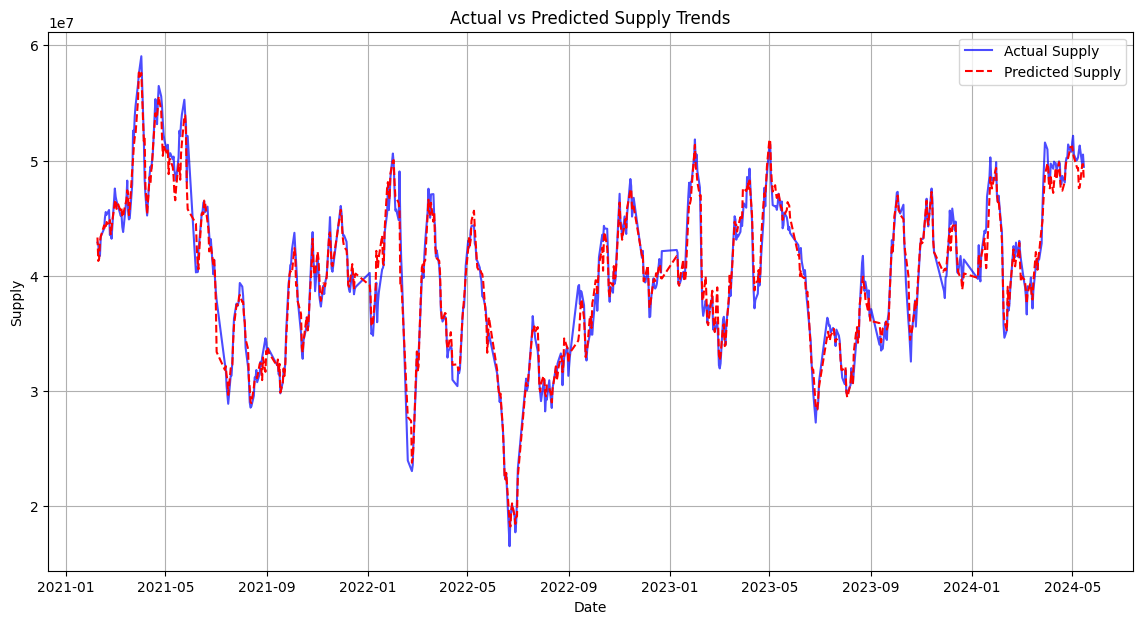

Future Predictions:
         Date  Supply Prediction
0  2024-05-16       4.949109e+07
1  2024-05-17       4.941294e+07
2  2024-05-18       4.941294e+07
3  2024-05-19       4.972482e+07
4  2024-05-20       4.991993e+07
5  2024-05-21       4.991764e+07
6  2024-05-22       4.990506e+07
7  2024-05-23       5.037278e+07
8  2024-05-24       5.012876e+07
9  2024-05-25       5.011529e+07
10 2024-05-26       4.899712e+07
11 2024-05-27       4.975068e+07
12 2024-05-28       4.973958e+07
13 2024-05-29       4.929278e+07
14 2024-05-30       4.927140e+07
15 2024-05-31       4.867530e+07
16 2024-06-01       4.867530e+07
17 2024-06-02       4.867530e+07
18 2024-06-03       4.895649e+07
19 2024-06-04       4.895231e+07
20 2024-06-05       4.851786e+07
21 2024-06-06       4.859040e+07
22 2024-06-07       4.836625e+07
23 2024-06-08       4.821394e+07
24 2024-06-09       4.809307e+07
25 2024-06-10       4.826137e+07
26 2024-06-11       4.774971e+07
27 2024-06-12       4.669611e+07
28 2024-06-13       4.5

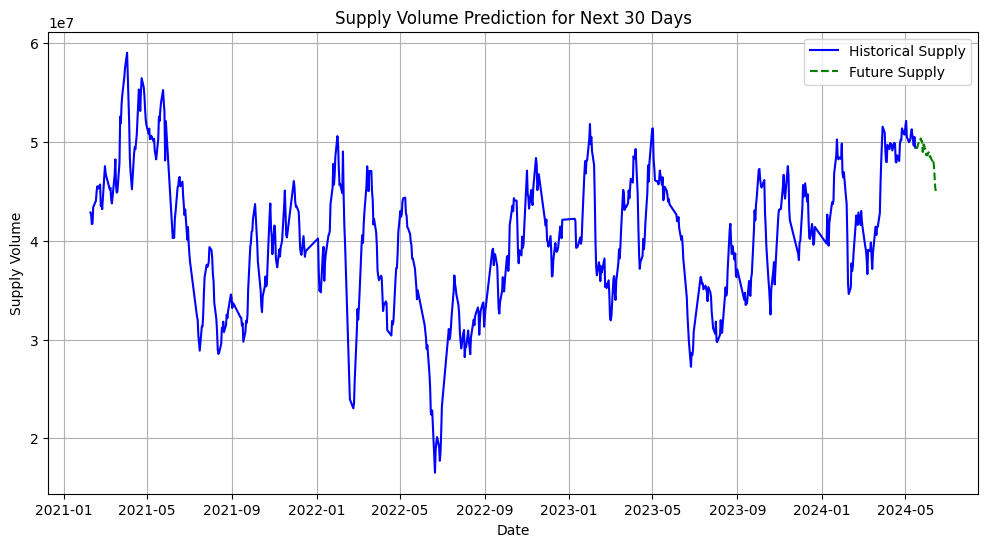

In [10]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from datetime import timedelta
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------
supply_data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')

# Handle missing values
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)
supply_data.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Convert 'Date' to datetime format
supply_data['Date'] = pd.to_datetime(supply_data['Date'], format='%m/%d/%Y')

# Feature Engineering: Create time-related features
supply_data['DayOfYear'] = supply_data['Date'].dt.dayofyear
supply_data['WeekOfYear'] = supply_data['Date'].dt.isocalendar().week
supply_data['Month'] = supply_data['Date'].dt.month
supply_data['DayOfWeek'] = supply_data['Date'].dt.dayofweek

# -------------------------------
# 2. Define Features and Target
# -------------------------------
features = ['72 Day Temperature', '72 Day Precipitation', 'DayOfYear', 'WeekOfYear', 'Month', 'DayOfWeek']
target = 'Supply'

X = supply_data[features]
y = supply_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 3. Train LightGBM Model with Cross-Validation
# -------------------------------
# LightGBM parameters
# Create the LightGBM datasets with feature_pre_filter explicitly set to False
train_data = lgb.Dataset(X_train, label=y_train, params={'feature_pre_filter': False})
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, params={'feature_pre_filter': False})

# Updated parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    'min_data_in_leaf': 10,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.2,
    'max_bin': 255,
    'verbosity': -1
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100)],
)

# -------------------------------
# 4. Evaluate Model
# -------------------------------
# Test set predictions
y_pred = np.mean([model.predict(X_test) for model in models], axis=0)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R^2: {r2:.2f}")

# -------------------------------
# 5. Visualize Trends in Historical Data
# -------------------------------
# Predict for the entire dataset
supply_data['Predicted Supply'] = np.mean([model.predict(X) for model in models], axis=0)

# Plot actual vs predicted trends
plt.figure(figsize=(14, 7))
plt.plot(supply_data['Date'], supply_data['Supply'], label='Actual Supply', color='blue', alpha=0.7)
plt.plot(supply_data['Date'], supply_data['Predicted Supply'], label='Predicted Supply', color='red', linestyle='--')
plt.title('Actual vs Predicted Supply Trends')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 6. Predict Future Supply
# -------------------------------
time_period = 30  # Predict next 30 days

# Generate future dates
last_date = supply_data['Date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, time_period + 1)]

# Create a DataFrame for future data
future_features = pd.DataFrame({
    'Date': future_dates,
    '72 Day Temperature': supply_data['72 Day Temperature'].iloc[-7:].mean(),
    '72 Day Precipitation': supply_data['72 Day Precipitation'].iloc[-7:].mean()
})

# Add time-based features
future_features['DayOfYear'] = future_features['Date'].dt.dayofyear
future_features['WeekOfYear'] = future_features['Date'].dt.isocalendar().week
future_features['Month'] = future_features['Date'].dt.month
future_features['DayOfWeek'] = future_features['Date'].dt.dayofweek

# Predict future supply
future_features['Supply Prediction'] = np.mean([model.predict(future_features[features]) for model in models], axis=0)

# Display predictions
print("Future Predictions:")
print(future_features[['Date', 'Supply Prediction']])

# Plot historical and future predictions
plt.figure(figsize=(12, 6))
plt.plot(supply_data['Date'], supply_data['Supply'], label='Historical Supply', color='blue')
plt.plot(future_features['Date'], future_features['Supply Prediction'], label='Future Supply', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Supply Volume')
plt.title(f'Supply Volume Prediction for Next {time_period} Days')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Define LightGBM parameters with added regularization
params = {
    'objective': 'regression',        # Regression task
    'metric': 'rmse',                # Root Mean Squared Error as the evaluation metric
    'boosting_type': 'gbdt',         # Gradient Boosted Decision Trees
    'num_leaves': 31,                # Maximum number of leaves in one tree
    'learning_rate': 0.05,           # Learning rate
    'feature_fraction': 0.9,         # Fraction of features used for training
    'lambda_l1': 0.1,                # L1 regularization (Lasso)
    'lambda_l2': 0.1,                # L2 regularization (Ridge)
    'bagging_fraction': 0.8,         # Subsample ratio of the training instances
    'bagging_freq': 5,               # Frequency of bagging
}

# Prepare the LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	training's rmse: 566388	valid_1's rmse: 1.93709e+06
RMSE: 1937093.41, MAE: 1456623.35, R²: 0.92


C:\Users\Patron\AppData\Local\Temp\ipykernel_22840\1553256930.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  supply_data['Seasonality_Index'].fillna(method='bfill', inplace=True)
C:\Users\Patron\AppData\Local\Temp\ipykernel_22840\1553256930.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  supply_data['Seasonality_Index'].fillna(method='bfill', inplace=True)
C:\Users\Patron\AppData\Local\Temp\ipykernel_22840\1553256930.py:41: Futu

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 1.8862e+06
RMSE: 1886204.41, MAE: 1387246.72, R²: 0.93


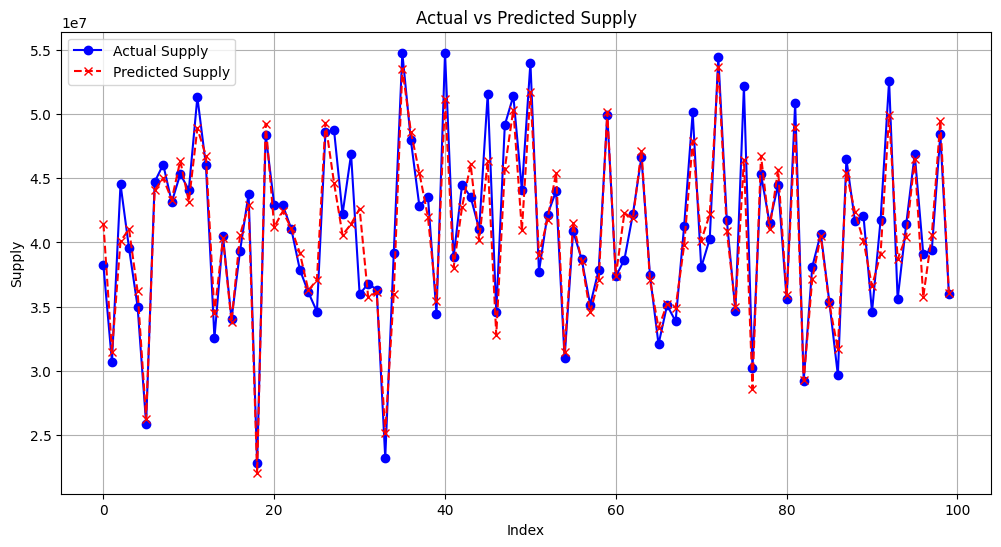

         Date  Supply Prediction
0  2024-05-16       3.794175e+07
1  2024-05-17       3.831949e+07
2  2024-05-18       4.051077e+07
3  2024-05-19       3.842821e+07
4  2024-05-20       3.914347e+07
5  2024-05-21       3.998638e+07
6  2024-05-22       4.480886e+07
7  2024-05-23       4.627539e+07
8  2024-05-24       4.134906e+07
9  2024-05-25       4.285218e+07
10 2024-05-26       4.346103e+07
11 2024-05-27       4.397547e+07
12 2024-05-28       4.358772e+07
13 2024-05-29       4.362498e+07
14 2024-05-30       4.391157e+07
15 2024-05-31       4.371528e+07
16 2024-06-01       4.345463e+07
17 2024-06-02       4.407798e+07
18 2024-06-03       4.168353e+07
19 2024-06-04       4.409122e+07
20 2024-06-05       4.358008e+07
21 2024-06-06       4.375120e+07
22 2024-06-07       4.441718e+07
23 2024-06-08       4.455422e+07
24 2024-06-09       4.332362e+07
25 2024-06-10       4.633555e+07
26 2024-06-11       4.632644e+07
27 2024-06-12       4.399704e+07
28 2024-06-13       4.365314e+07
29 2024-06

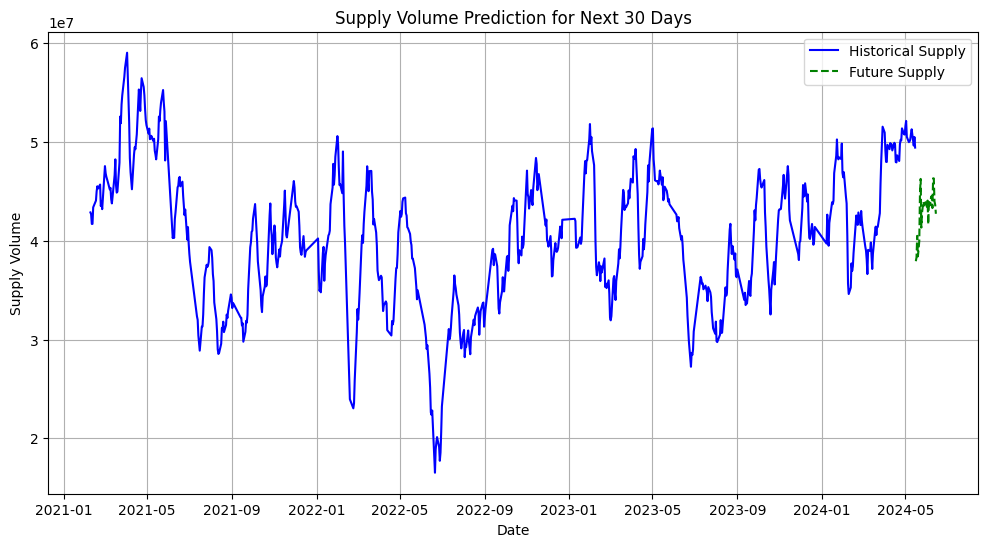

In [13]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------
# Load data
supply_data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')

# Preprocess 'Supply' column by removing commas and converting to numeric
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)

# Convert 'Date' to datetime format
supply_data['Date'] = pd.to_datetime(supply_data['Date'], format='%m/%d/%Y')

# Create time-related features
supply_data['DayOfYear'] = supply_data['Date'].dt.dayofyear
supply_data['WeekOfYear'] = supply_data['Date'].dt.isocalendar().week
supply_data['Month'] = supply_data['Date'].dt.month
supply_data['DayOfWeek'] = supply_data['Date'].dt.dayofweek

# -------------------------------
# 2. Add Seasonality Index
# -------------------------------
# Decompose the time series
supply_data.set_index('Date', inplace=True)  # Set Date as the index for decomposition
decomposition = seasonal_decompose(supply_data['Supply'], model='additive', period=365)

# Extract the seasonal component
supply_data['Seasonality_Index'] = decomposition.seasonal
supply_data.reset_index(inplace=True)  # Reset the index to include Date

# Handle missing seasonal values
supply_data['Seasonality_Index'].fillna(method='bfill', inplace=True)
supply_data['Seasonality_Index'].fillna(method='ffill', inplace=True)

# -------------------------------
# 3. Define Features and Target
# -------------------------------
features = ['72 Day Temperature', '72 Day Precipitation', 'DayOfYear', 'WeekOfYear', 'Month', 'DayOfWeek', 'Seasonality_Index']
target = 'Supply'

X = supply_data[features]
y = supply_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 4. Train LightGBM Model
# -------------------------------
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, params={'feature_pre_filter': False})
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, params={'feature_pre_filter': False})

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 15,                # Simpler trees
    'min_data_in_leaf': 20,          # Minimum samples per leaf
    'learning_rate': 0.01,           # Slower learning rate
    'feature_fraction': 0.7,         # Use 70% of features per iteration
    'bagging_fraction': 0.7,         # Use 70% of data per iteration
    'bagging_freq': 5,               # Perform bagging every 5 iterations
    'lambda_l1': 0.5,                # L1 regularization
    'lambda_l2': 0.5,                # L2 regularization
    'max_bin': 255,                  # Number of bins for histogram
    'verbosity': -1                  # Suppress logs
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=3000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

# -------------------------------
# 5. Evaluate Model Performance
# -------------------------------
# Predict on test data
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# -------------------------------
# 6. Visualize Actual vs Predicted
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual Supply', color='blue', marker='o')
plt.plot(y_pred[:100], label='Predicted Supply', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Supply')
plt.xlabel('Index')
plt.ylabel('Supply')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 7. Predict Future Supply
# -------------------------------
# Define prediction time period
time_period = 30  # Predict for the next 30 days

# Generate future dates
last_date = supply_data['Date'].max()
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, time_period + 1)]

# Create a DataFrame for future data
future_features = pd.DataFrame({
    'Date': future_dates,
    '72 Day Temperature': X_train['72 Day Temperature'].mean(),  # Use training mean for simplicity
    '72 Day Precipitation': X_train['72 Day Precipitation'].mean(),
    'DayOfYear': [date.dayofyear for date in future_dates],
    'WeekOfYear': [date.isocalendar().week for date in future_dates],
    'Month': [date.month for date in future_dates],
    'DayOfWeek': [date.dayofweek for date in future_dates],
})

# Add seasonality index to future dates
future_features['Seasonality_Index'] = decomposition.seasonal[:time_period].tolist()  # Reuse seasonal pattern

# Predict future supply
future_features['Supply Prediction'] = model.predict(future_features[features])

# Display future predictions
print(future_features[['Date', 'Supply Prediction']])

# Plot historical and future predictions
plt.figure(figsize=(12, 6))
plt.plot(supply_data['Date'], supply_data['Supply'], label='Historical Supply', color='blue')
plt.plot(future_features['Date'], future_features['Supply Prediction'], label='Future Supply', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Supply Volume')
plt.title(f'Supply Volume Prediction for Next {time_period} Days')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Patron\AppData\Local\Temp\ipykernel_12220\1303506163.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  supply_data['Seasonality_Index'].fillna(method='bfill', inplace=True)
C:\Users\Patron\AppData\Local\Temp\ipykernel_12220\1303506163.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  supply_data['Seasonality_Index'].fillna(method='bfill', inplace=True)
C:\Users\Patron\AppData\Local\Temp\ipykernel_12220\1303506163.py:41: Futu

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2990]	valid_0's rmse: 1.96306e+06
RMSE: 1963057.71, MAE: 1478040.75, R²: 0.92
         Date  Supply Prediction
0  2024-05-16       4.953409e+07
1  2024-05-17       4.984241e+07
2  2024-05-18       5.033346e+07
3  2024-05-19       5.000277e+07
4  2024-05-20       4.989166e+07
5  2024-05-21       4.997632e+07
6  2024-05-22       5.049913e+07
7  2024-05-23       5.072125e+07
8  2024-05-24       5.036480e+07
9  2024-05-25       5.079932e+07
10 2024-05-26       5.023527e+07
11 2024-05-27       4.937841e+07
12 2024-05-28       4.937438e+07
13 2024-05-29       4.925593e+07
14 2024-05-30       4.940308e+07
15 2024-05-31       4.966804e+07
16 2024-06-01       4.963452e+07
17 2024-06-02       5.041119e+07
18 2024-06-03       4.981556e+07
19 2024-06-04       5.026874e+07
20 2024-06-05       5.008427e+07
21 2024-06-06       4.979149e+07
22 2024-06-07       5.062887e+07
23 2024-06-08       

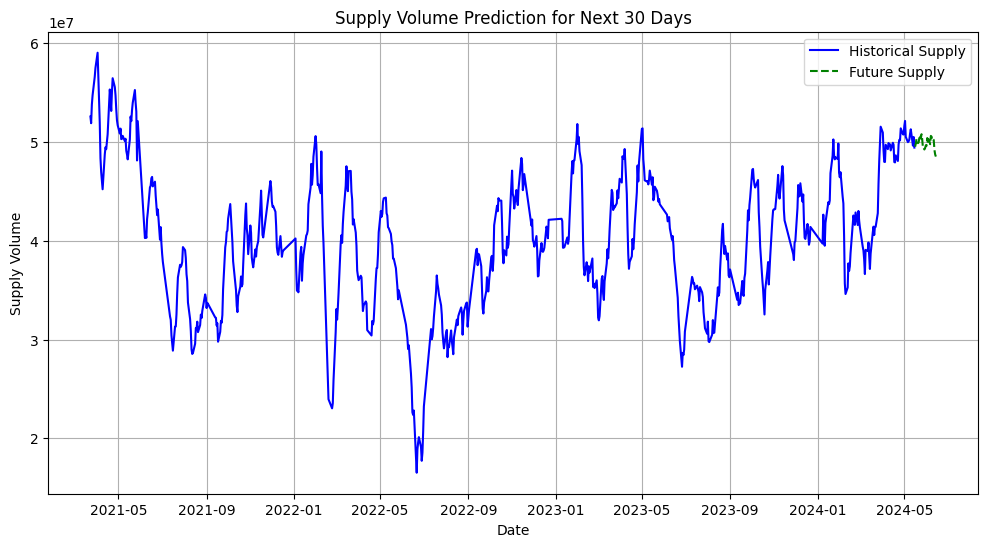

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------
# Load data
supply_data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')

# Preprocess 'Supply' column by removing commas and converting to numeric
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)

# Convert 'Date' to datetime format
supply_data['Date'] = pd.to_datetime(supply_data['Date'], format='%m/%d/%Y')

# Create time-related features
supply_data['DayOfYear'] = supply_data['Date'].dt.dayofyear
supply_data['WeekOfYear'] = supply_data['Date'].dt.isocalendar().week
supply_data['Month'] = supply_data['Date'].dt.month
supply_data['DayOfWeek'] = supply_data['Date'].dt.dayofweek

# -------------------------------
# 2. Add Seasonality and Fourier Features
# -------------------------------
# Decompose the time series
supply_data.set_index('Date', inplace=True)  # Set Date as the index for decomposition
decomposition = seasonal_decompose(supply_data['Supply'], model='additive', period=365)

# Extract the seasonal component
supply_data['Seasonality_Index'] = decomposition.seasonal
supply_data.reset_index(inplace=True)  # Reset the index to include Date

# Handle missing seasonal values
supply_data['Seasonality_Index'].fillna(method='bfill', inplace=True)
supply_data['Seasonality_Index'].fillna(method='ffill', inplace=True)

# Add Fourier Transform features
supply_data['Fourier_Sin'] = np.sin(2 * np.pi * supply_data['DayOfYear'] / 365.25)
supply_data['Fourier_Cos'] = np.cos(2 * np.pi * supply_data['DayOfYear'] / 365.25)

# -------------------------------
# 3. Add Lag and Rolling Features
# -------------------------------
# Lag features
supply_data['Lag_7'] = supply_data['Supply'].shift(7)
supply_data['Lag_30'] = supply_data['Supply'].shift(30)

# Rolling statistics
supply_data['Rolling_Mean_7'] = supply_data['Supply'].rolling(7).mean()
supply_data['Rolling_Std_7'] = supply_data['Supply'].rolling(7).std()

# Drop rows with NaN values caused by lag/rolling calculations
supply_data.dropna(inplace=True)

# -------------------------------
# 4. Define Features and Target
# -------------------------------
features = [
    '72 Day Temperature', '72 Day Precipitation', 'DayOfYear', 'WeekOfYear',
    'Month', 'DayOfWeek', 'Seasonality_Index', 'Fourier_Sin', 'Fourier_Cos',
    'Lag_7', 'Lag_30', 'Rolling_Mean_7', 'Rolling_Std_7'
]
target = 'Supply'

X = supply_data[features]
y = supply_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 5. Train LightGBM Model
# -------------------------------
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, params={'feature_pre_filter': False})
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, params={'feature_pre_filter': False})

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 20,                # Simpler trees
    'min_data_in_leaf': 50,          # Larger leaves to reduce overfitting
    'learning_rate': 0.01,           # Slower learning rate
    'feature_fraction': 0.7,         # Use 70% of features per iteration
    'bagging_fraction': 0.7,         # Use 70% of data per iteration
    'bagging_freq': 5,               # Perform bagging every 5 iterations
    'lambda_l1': 0.1,                # Stronger L1 regularization
    'lambda_l2': 0.1,                # Stronger L2 regularization
    'max_bin': 255,                  # Number of bins for histogram
    'verbosity': -1                  # Suppress logs
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=3000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)

# -------------------------------
# 6. Evaluate Model Performance
# -------------------------------
# Predict on test data
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# -------------------------------
# 7. Predict Future Supply
# -------------------------------
# Define prediction time period
time_period = 30  # Predict for the next 30 days

# Generate future dates
last_date = supply_data['Date'].max()
# Predict Future Supply (Fix for Lag and Rolling Features)
# Generate future dates
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, time_period + 1)]

# Create a DataFrame for future data
future_features = pd.DataFrame({
    'Date': future_dates,
    '72 Day Temperature': X_train['72 Day Temperature'].mean(),  # Use training mean for simplicity
    '72 Day Precipitation': X_train['72 Day Precipitation'].mean(),
    'DayOfYear': [date.dayofyear for date in future_dates],
    'WeekOfYear': [date.isocalendar().week for date in future_dates],
    'Month': [date.month for date in future_dates],
    'DayOfWeek': [date.dayofweek for date in future_dates],
})

# Add seasonality and Fourier features to future data
future_features['Seasonality_Index'] = decomposition.seasonal[:time_period].tolist()  # Reuse seasonal pattern
future_features['Fourier_Sin'] = np.sin(2 * np.pi * future_features['DayOfYear'] / 365.25)
future_features['Fourier_Cos'] = np.cos(2 * np.pi * future_features['DayOfYear'] / 365.25)

# Add lag features using the last known values from training data
future_features['Lag_7'] = supply_data['Supply'].iloc[-7]  # Last known lag-7 value
future_features['Lag_30'] = supply_data['Supply'].iloc[-30]  # Last known lag-30 value

# Add rolling features using the last available segment of historical data
future_features['Rolling_Mean_7'] = supply_data['Supply'].iloc[-7:].mean()
future_features['Rolling_Std_7'] = supply_data['Supply'].iloc[-7:].std()

# Predict future supply
future_features['Supply Prediction'] = model.predict(future_features[features])

# Display future predictions
print(future_features[['Date', 'Supply Prediction']])

# Plot historical and future predictions
plt.figure(figsize=(12, 6))
plt.plot(supply_data['Date'], supply_data['Supply'], label='Historical Supply', color='blue')
plt.plot(future_features['Date'], future_features['Supply Prediction'], label='Future Supply', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Supply Volume')
plt.title(f'Supply Volume Prediction for Next {time_period} Days')
plt.legend()
plt.grid(True)
plt.show()

